In [36]:
import numpy as np
import pandas as pd
import tempfile
temp_dir = tempfile.TemporaryDirectory()
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import time

from __future__ import division
from scipy.stats import pearsonr

import mlflow
import mlflow.sklearn

## Récupération des données


In [37]:
# import Data
# https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv

data = pd.read_csv('../data/flat_data.csv')

# on convertit en datetime notre colonne de date
data["date"] = pd.to_datetime(data["date"])
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,coef_ajustement
0,5561000190,2014-05-02,4.375000e+05,3,2.25,1970,35100,2.0,0,0,...,1970,0,1977,0,98027,47.4635,-121.991,2340,35100,1.000000
1,472000620,2014-05-02,7.900000e+05,3,2.50,2600,4750,1.0,0,0,...,1700,900,1951,0,98117,47.6833,-122.400,2380,4750,1.000000
2,1024069009,2014-05-02,6.750000e+05,5,2.50,2820,67518,2.0,0,0,...,2820,0,1979,0,98029,47.5794,-122.025,2820,48351,1.000000
3,7853361370,2014-05-02,5.550000e+05,4,2.50,3310,6500,2.0,0,0,...,3310,0,2012,0,98065,47.5150,-121.870,2380,5000,1.000000
4,5056500260,2014-05-02,4.400000e+05,4,2.25,2160,8119,1.0,0,0,...,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1422700040,2015-05-14,2.102280e+05,3,1.00,1170,7320,1.0,0,0,...,1170,0,1962,0,98188,47.4685,-122.282,2040,7320,1.148787
21609,8730000270,2015-05-14,4.124146e+05,2,2.75,1370,1140,2.0,0,0,...,1080,290,2009,0,98133,47.7052,-122.343,1370,1090,1.148787
21610,7923600250,2015-05-15,5.171361e+05,5,2.00,1870,7344,1.5,0,0,...,1870,0,1960,0,98007,47.5951,-122.144,1870,7650,1.149191
21611,5101400871,2015-05-24,5.121449e+05,2,1.75,1390,6670,1.0,0,0,...,720,670,1941,0,98115,47.6914,-122.308,920,6380,1.149596


199.87594413659517 -146437062.5799215


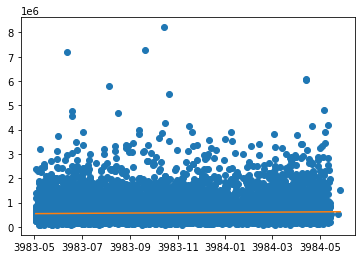

In [38]:
# on trace la régréssion linéaire entre le prix et la date (ordinale)
(a,b)=np.polyfit(data["date"].map(dt.datetime.toordinal),data['price'],1)

# on affiche les coefficients de regression
print(a,b)

plt.plot_date(data["date"].map(dt.datetime.toordinal), data['price'], fmt='o', tz=None, xdate=True, ydate=False)
plt.plot(data["date"].map(dt.datetime.toordinal),data["date"].map(dt.datetime.toordinal)*a+b)
# on observe qu'il y a une augmentation du prix moyen de vente en fonction du temps

## Étude des corrélations entre features et price



In [5]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]


,Value
sqft_living vs price,0.697072
grade vs price,0.662982
sqft_above vs price,0.601451
sqft_living15 vs price,0.581688
bathrooms vs price,0.521281
view vs price,0.395809
sqft_basement vs price,0.321219
bedrooms vs price,0.306284
lat vs price,0.305024
waterfront vs price,0.265865


Fonctions utiles pour extraction et évaluation

In [39]:
# fonction pour évaluer nos prédictions

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [40]:
# fonction qui nous renvoit un x (12features) et un Y(price) à partir du dataset ajusté sur un interval entre deux dates
def extract_interval(start_date,end_date):
    try:
        # on filtre sur notre interval de date
        mask = (data['date'] >= start_date) & (data['date'] <= end_date)
        data_prep = data.loc[mask]
    
    except Exception as ex:
        print(ex)
        raise print("mauvais format de dates, attendu AAAA-MM-JJ")
    x= data_prep[['view','lat','waterfront','bedrooms','bathrooms','sqft_basement','sqft_above','sqft_living','sqft_living15','floors','grade','yr_built']]

    Y = data_prep['price']
    return x,Y

## Création Regression lineaire

In [51]:
# on entraine puis test notre modèle de Mai à Décembre
start_date = '2014-05-01'
end_date = "2014-11-01"
x,Y = extract_interval(start_date,end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

# on indique quelle expérience, nous voulons créer/utiliser
mlflow.set_experiment("pricing_prediction")

with mlflow.start_run():

    regLin = LinearRegression()
    regLin.fit(x_train, y_train)
    predicted_prices = regLin.predict(x_test)
    (rmse,mae,r2) = eval_metrics(y_test,predicted_prices)

    print("model trained with date interval",start_date,'->',end_date)
    print("number of row trained",len(y_train))
    print("number of row tested",len(y_test),"\n")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    #log param and metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    #log artifact
    # save training dataset
    x_train.loc[:,'price']=y_train.values
    x_train.to_csv(tempfile.gettempdir()+'/training_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/training_dataset.csv')
    
    #save testing dataset
    x_test.loc[:,'price']=y_test.values
    x_test.to_csv(tempfile.gettempdir()+'/testing_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/testing_dataset.csv')

    #set tag
    mlflow.set_tag("mlflow.note.content","Linear Regressor\nTraining period : "+start_date+" to "+end_date)

    #log model
    mlflow.sklearn.log_model(regLin, "model")

    mlflow.end_run()


model trained with date interval 2014-05-01 -> 2014-11-01
number of row trained 9404
number of row tested 2352 

  RMSE: 218663.09168156114
  MAE: 129299.19684450823
  R2: 0.6954304664189723
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

## Création Random Forest

In [52]:
# on entraine puis test notre modèle de Mai à Octobre
start_date = '2014-05-01'
end_date = "2014-11-01"
x,Y = extract_interval(start_date,end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

n_estimators=150
# on indique quelle expérience, nous voulons créer/utiliser
# mlflow.set_experiment("mon_expérience")
mlflow.set_experiment("pricing_prediction")

with mlflow.start_run():

    regRF = RandomForestRegressor(n_estimators=n_estimators)
    regRF.fit(x_train, y_train)
   
    # enregistrer avec mlflow :
    #   - params
    #   - metrics
    #   - model
    #   - artifact(dataset de training)
    #   - tag (notes) : décrire sur quelle période le modèle a été entrainé

    # https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.log_model
    # exemple pour param et metrics
    # 
    # mlflow.log_param("param", exemple_param)
    # mlflow.log_metric("precision", exemple_predicision)

    # --------------------------------------
    #               corection 
    # --------------------------------------

    

    predicted_prices = regRF.predict(x_test)
    (rmse,mae,r2) = eval_metrics(y_test,predicted_prices)
    print("model trained with date interval",start_date,'->',end_date)
    print("number of row trained",len(y_train))
    print("number of row tested",len(y_test),"\n")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    #log param and metrics
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    #log artifact
    # save training dataset
    x_train.loc[:,'price']=y_train.values
    x_train.to_csv(tempfile.gettempdir()+'/training_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/training_dataset.csv')
    
    #save testing dataset
    x_test.loc[:,'price']=y_test.values
    x_test.to_csv(tempfile.gettempdir()+'/testing_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/testing_dataset.csv')

    #set tag
    mlflow.set_tag("mlflow.note.content","Random Forest\nTraining period : "+start_date+" to "+end_date)

    #log model
    mlflow.sklearn.log_model(regRF, "model")

    mlflow.end_run()


model trained with date interval 2014-05-01 -> 2014-11-01
number of row trained 9404
number of row tested 2352 

  RMSE: 172884.76876230352
  MAE: 87869.04609541017
  R2: 0.8096078858464882
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

### Création Random Forest 
#### avec données de Main 2014 à Février 2015

In [53]:
# on entraine puis test notre modèle sur une plus grande période
start_date = '2014-05-01'
end_date = "2015-02-01"
x,Y = extract_interval(start_date,end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

n_estimators=150
# on indique quelle expérience, nous voulons créer/utiliser
# mlflow.set_experiment("mon_expérience")
mlflow.set_experiment("pricing_prediction")

with mlflow.start_run():

    regRF = RandomForestRegressor(n_estimators=n_estimators)
    regRF.fit(x_train, y_train)
   
    # enregistrer avec mlflow :
    #   - params
    #   - metrics
    #   - model
    #   - artifact(dataset de training)
    #   - tag (notes) : décrire sur quelle période le modèle a été entrainé

    # https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.log_model
    # exemple pour param et metrics
    # 
    # mlflow.log_param("param", exemple_param)
    # mlflow.log_metric("precision", exemple_predicision)

    # --------------------------------------
    #               corection 
    # --------------------------------------

    

    predicted_prices = regRF.predict(x_test)
    (rmse,mae,r2) = eval_metrics(y_test,predicted_prices)
    print("model trained with date interval",start_date,'->',end_date)
    print("number of row trained",len(y_train))
    print("number of row tested",len(y_test),"\n")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    #log param and metrics
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    #log artifact
    # save training dataset
    x_train.loc[:,'price']=y_train.values
    x_train.to_csv(tempfile.gettempdir()+'/training_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/training_dataset.csv')
    
    #save testing dataset
    x_test.loc[:,'price']=y_test.values
    x_test.to_csv(tempfile.gettempdir()+'/testing_dataset.csv',index=False)
    mlflow.log_artifact(tempfile.gettempdir()+'/testing_dataset.csv')

    #set tag
    mlflow.set_tag("mlflow.note.content","Random Forest\nTraining period : "+start_date+" to "+end_date)

    #log model
    mlflow.sklearn.log_model(regRF, "model")

    mlflow.end_run()


model trained with date interval 2014-05-01 -> 2015-02-01
number of row trained 12490
number of row tested 3123 

  RMSE: 155879.2210766628
  MAE: 86039.33412336135
  R2: 0.8283927304447265
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/martincudicio/opt/anaconda3/envs/env_train/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a